In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_excel('train.xlsx')
df_test = pd.read_excel('test.xlsx')

In [ ]:
#df_train = df_train[df_train.columns[df_train[df_train.columns].count() > 5000]]
#df_test = df_test[df_train.drop('Energ_Kcal', axis = 1).columns]

## Preprocess

In [4]:
df_train.isnull().sum()

Shrt_Desc               0
Water_(g)               5
Energ_Kcal              0
Protein_(g)             0
Lipid_Tot_(g)           0
Ash_(g)               295
Carbohydrt_(g)          0
Fiber_TD_(g)          588
Sugar_Tot_(g)        1743
Calcium_(mg)          313
Iron_(mg)             126
Magnesium_(mg)        617
Phosphorus_(mg)       522
Potassium_(mg)        366
Sodium_(mg)            75
Zinc_(mg)             633
Copper_mg)           1126
Manganese_(mg)       1928
Selenium_(µg)        1581
Vit_C_(mg)            703
Thiamin_(mg)          618
Riboflavin_(mg)       600
Niacin_(mg)           619
Panto_Acid_mg)       1931
Vit_B6_(mg)           847
Folate_Tot_(µg)      1117
Folic_Acid_(µg)      1781
Food_Folate_(µg)     1578
Folate_DFE_(µg)      1798
Choline_Tot_ (mg)    3661
Vit_B12_(µg)         1071
Vit_A_IU              611
Vit_A_RAE            1369
Retinol_(µg)         1622
Alpha_Carot_(µg)     3024
Beta_Carot_(µg)      2941
Beta_Crypt_(µg)      3032
Lycopene_(µg)        3055
Lut+Zea_ (µg

In [ ]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False)

In [ ]:
sns.heatmap(df_test.isnull(),yticklabels=False,cbar=False)

In [38]:
to_drop = df_train.T[df_train.isnull().sum() > 2900].T.columns
df_test_drp = df_test.drop(columns = to_drop)
df_train_drp = df_train.drop(columns = to_drop)

In [ ]:
sns.heatmap(df_train_drp.isnull(),yticklabels=False,cbar=False)

In [ ]:
df_train_drp.T.isnull().sum().hist()

In [ ]:
df_train_drp = df_train_drp[df_train_drp.T.isnull().sum() < 15]

In [51]:
(df_train_drp.T.isnull().sum() < 29).sum()

7721

In [ ]:
sns.heatmap(df_train_drp.isnull(),yticklabels=False,cbar=False)

In [24]:
df_train_fixed = df_train_drp.select_dtypes(include=['number']).apply(lambda x : x.fillna(x.mean()))
df_test_fixed = df_test_drp.select_dtypes(include=['number']).apply(lambda x : x.fillna(x.mean()))

In [ ]:
df_test_fixed_0 = df_test_drp.select_dtypes(include=['number']).fillna(0)
df_train_fixed_0 = df_train_drp.select_dtypes(include=['number']).fillna(0)

In [5]:
df_test_fixed = df_test.select_dtypes(include=['number']).apply(lambda x : x.fillna(x.mean()))
df_train_fixed = df_train.select_dtypes(include=['number']).apply(lambda x : x.fillna(x.mean()))

In [25]:
X = df_train_fixed.drop(columns=['Energ_Kcal'])
y = df_train_fixed['Energ_Kcal']

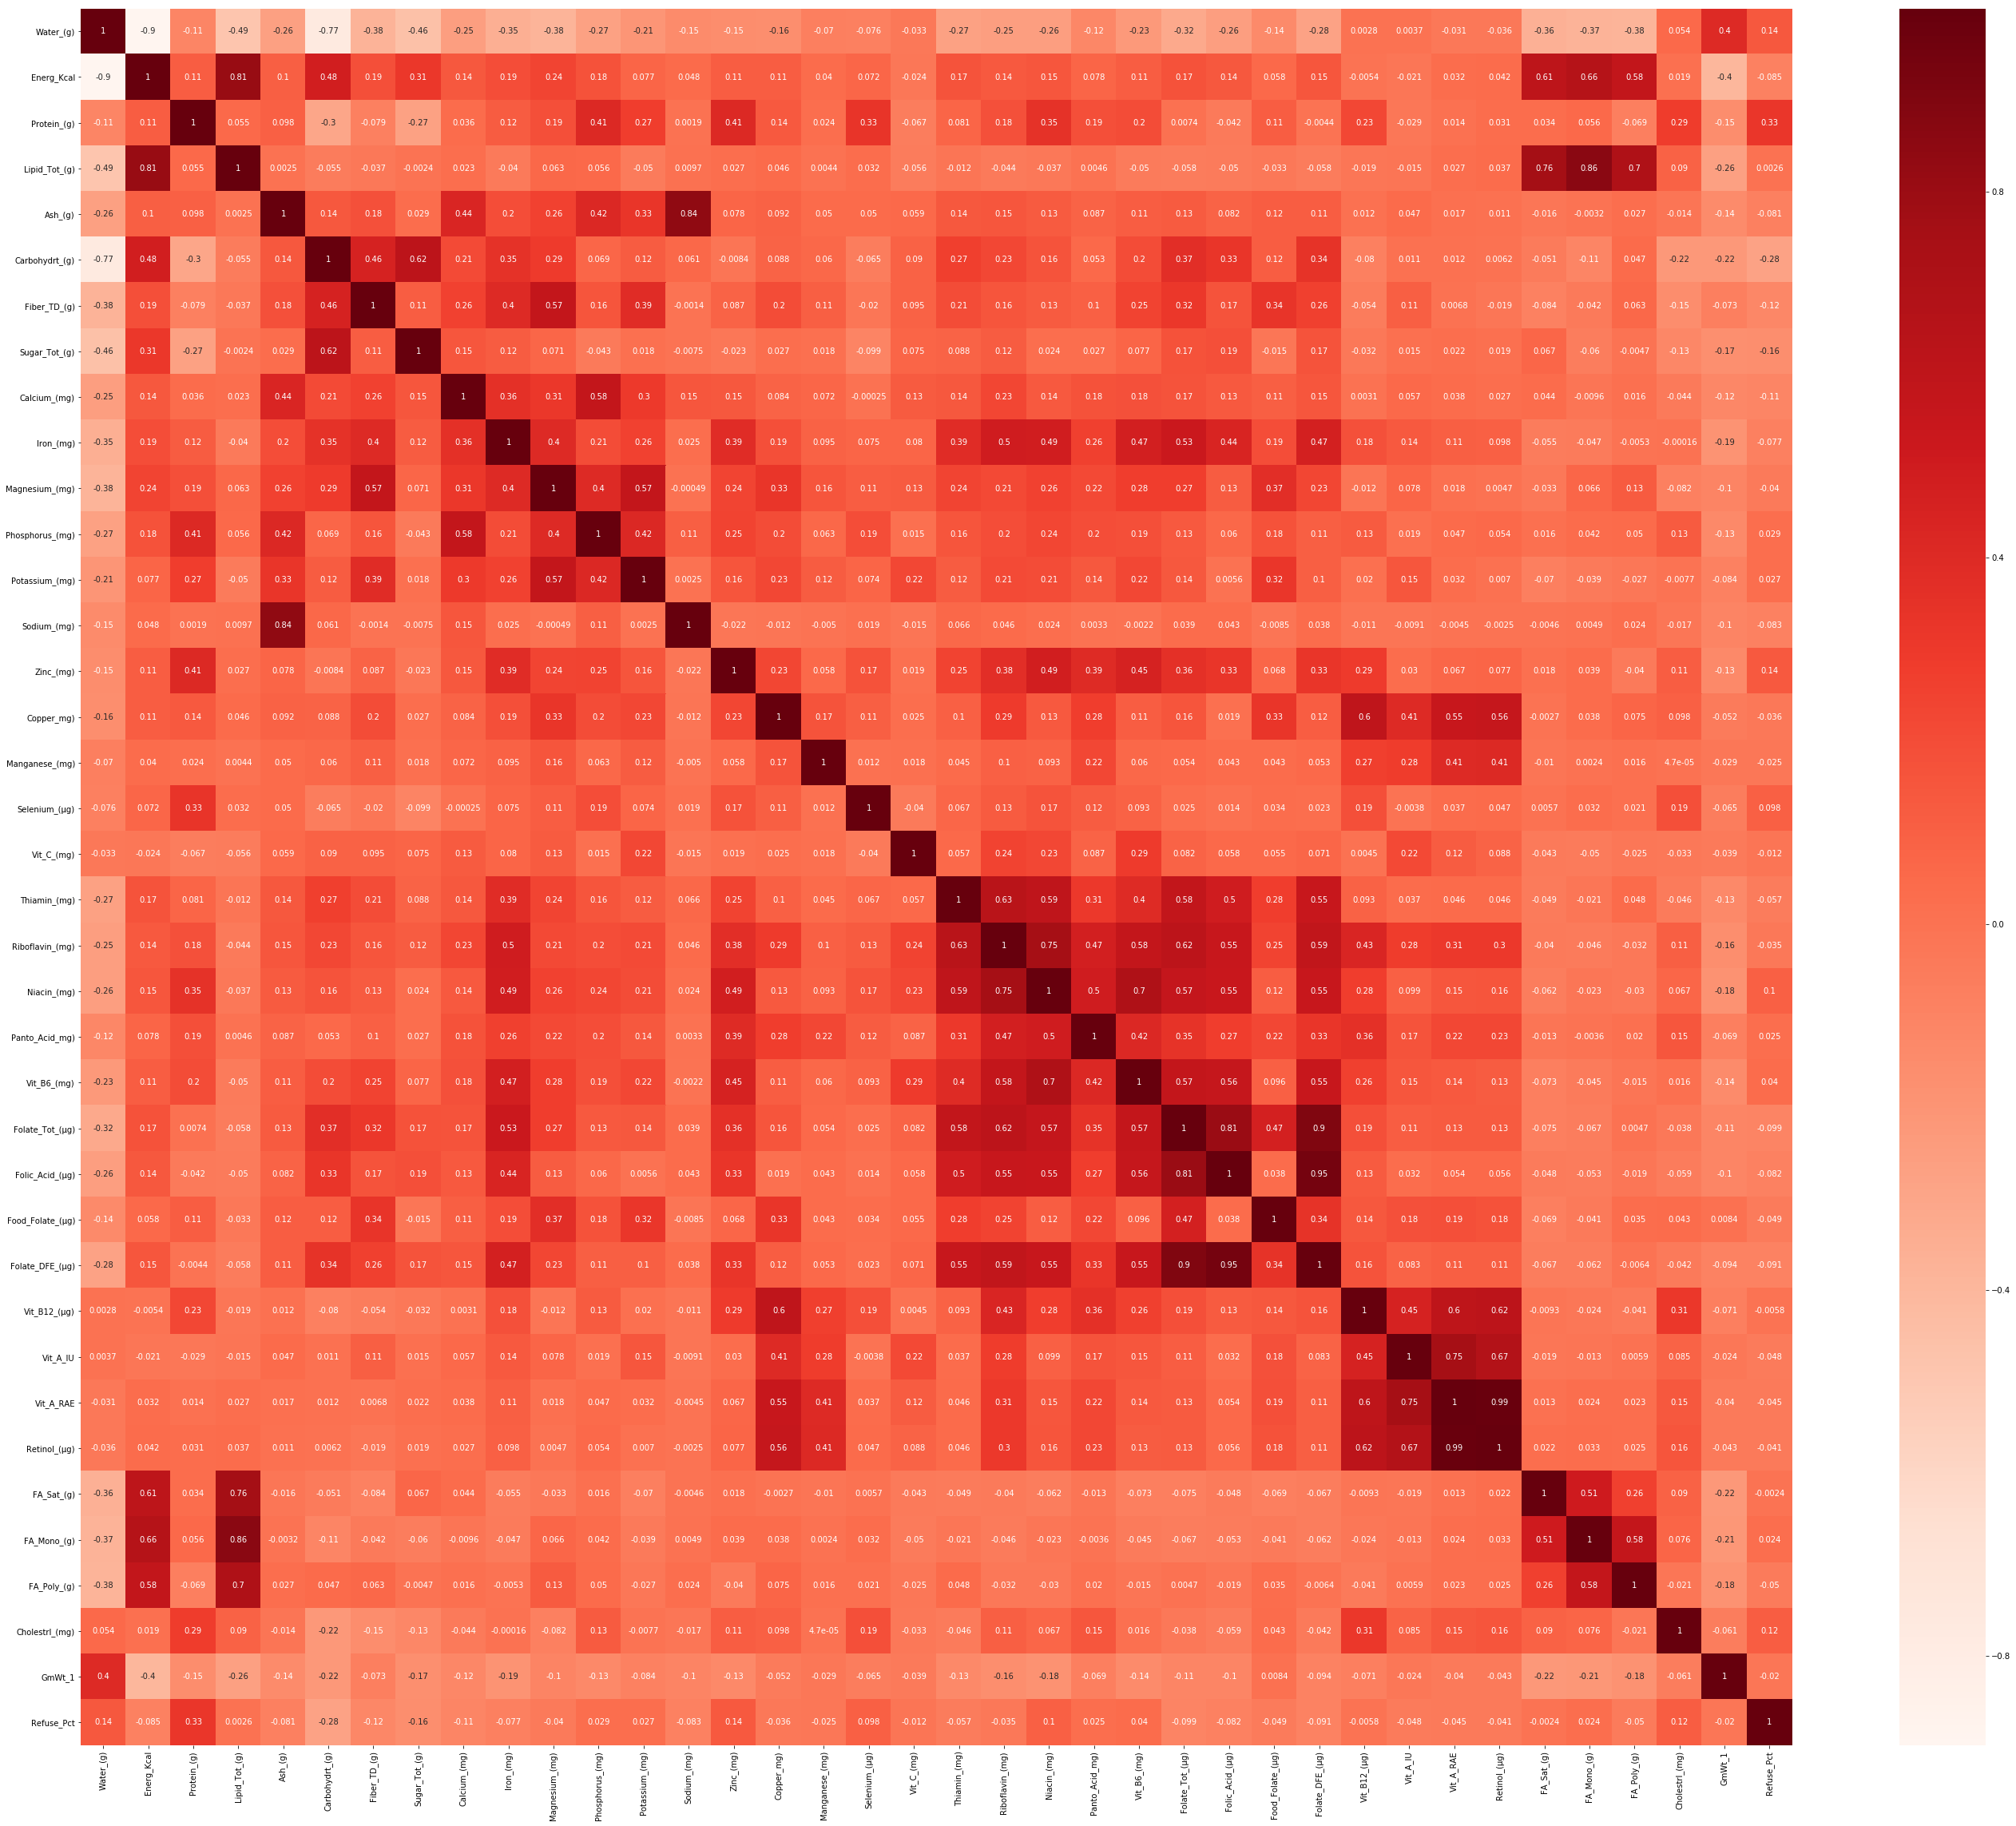

In [26]:
plt.figure(figsize=(48,40))
cor = df_train_fixed.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [27]:
cor_target = abs(cor["Energ_Kcal"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Water_(g)        0.897490
Energ_Kcal       1.000000
Lipid_Tot_(g)    0.809028
FA_Sat_(g)       0.611071
FA_Mono_(g)      0.663868
FA_Poly_(g)      0.584544
Name: Energ_Kcal, dtype: float64

## Основная задача (Регрессия)
Построить модель машинного обучения для предсказания калорийности продукта (Kcal)

In [ ]:
X = df_train_fixed.drop(columns=['Energ_Kcal'])
y = df_train_fixed['Energ_Kcal']

xgb_clf = XGBRegressor(n_estimators = 900, min_child_weight = 5, max_depth = 12, learning_rate= 0.03,
                       booster = 'gbtree', base_score = 0.5, n_jobs=-1)
xgb_clf.fit(X, y)
y_pred = xgb_clf.predict(df_test_fixed)

pd.DataFrame({'Pred_kcal' : pd.Series(y_pred)}).to_csv('Pred_main.csv')

## Experiments 0

In [ ]:
X = df_train_fixed.drop(columns=['Energ_Kcal'])
y = df_train_fixed['Energ_Kcal']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
xgb_clf = XGBRegressor(n_estimators = 900, min_child_weight = 5, max_depth = 12, learning_rate= 0.03,
                       booster = 'gbtree', base_score = 0.5, n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
y_pred = xgb_clf.predict(X_train)
mean_absolute_error(y_train, y_pred)

In [ ]:
s = 0
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    xgb_clf = XGBRegressor(n_estimators = 900, min_child_weight = 5, max_depth = 12, learning_rate= 0.03,
                       booster = 'gbtree', base_score = 0.5, n_jobs=-1)
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    m = mean_absolute_error(y_test, y_pred)
    print(m)
    s+=m
    print()
print('s=', s/10)

In [ ]:
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]



# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [ ]:
xgb_clf = XGBRegressor()
random_cv = RandomizedSearchCV(estimator=xgb_clf,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv.fit(X, y)

In [ ]:
random_cv.best_params_

In [ ]:
best_clf = random_cv.best_estimator_

In [ ]:
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
xgb_clf = XGBRegressor(n_estimators = 900, min_child_weight = 5, max_depth = 12, learning_rate= 0.03,
                       booster = 'gbtree', base_score = 0.5, n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
y_pred = xgb_clf.predict(X_train)
mean_absolute_error(y_train, y_pred)